# Comparative Analysis of Economic, Health, and Environmental Trends: DR Congo vs Burundi (1960–2023)
<h1>INTRODUCTION</h1>
This analysis explores long-term development trends in DR Congo and Burundi between 1960 and 2023, using data from the World Bank. The focus is on three critical indicators that reflect economic performance, health outcomes, and environmental impact:

- GDP per capita (USD)
- Life Expectancy at Birth (Years)
- CO₂ Emissions per Capita (Metric Tons)
 
These two Central African nations share a history of conflict, political instability, and underdevelopment, yet have also experienced varying degrees of recovery and reform. By comparing them side-by-side, we aim to uncover insights into how such factors influence key development metrics over time.

In [1]:
# 📦 Imports the libraries
import wbgapi as wb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings


# 🚫 Suppress all warnings
warnings.filterwarnings('ignore')


In [2]:
# Define the World Bank indicators to retrieve:
indicators = ['NY.GDP.PCAP.CD', 'SP.DYN.LE00.IN', 'EN.GHG.CO2.PC.CE.AR5']

# Define the countries of interest with ISO codes:
countries = {'Burundi': 'BDI', 'DR Congo': 'COD'}


dfs = {}  # Dictionary to store each country's DataFrame

In [3]:
for name, code in countries.items():
    # Use wbgapi to download data for the specified indicators and country
    df = wb.data.DataFrame(indicators, code, time=range(1960, 2024),
                           columns='series', skipBlanks=True).reset_index()
    
    # Extract the year as a 4-digit integer from the time index
    df['Year'] = df['time'].str.extract(r'(\d{4})').astype(int)
    
    # Rename indicator columns for clarity
    df = df.rename(columns={
        'NY.GDP.PCAP.CD': 'GDP',
        'SP.DYN.LE00.IN': 'Life Expectancy',
        'EN.GHG.CO2.PC.CE.AR5': 'CO2'
    })
    
    # Add a column to identify the country name
    df['Country'] = name
    
    # Select relevant columns only
    dfs[name] = df[['Year', 'GDP', 'Life Expectancy', 'CO2', 'Country']]

# Concatenate country-specific data into one dataset
data = pd.concat(dfs.values()) 

In [4]:
data.groupby('Country').describe().T

Country                    Burundi     DR Congo
Year            count    64.000000    64.000000
                mean   1991.500000  1991.500000
                std      18.618987    18.618987
                min    1960.000000  1960.000000
                25%    1975.750000  1975.750000
                50%    1991.500000  1991.500000
                75%    2007.250000  2007.250000
                max    2023.000000  2023.000000
GDP             count    64.000000    64.000000
                mean    160.038000   322.106661
                std      63.560179   145.704279
                min      50.613304    96.319224
                25%     111.276219   217.487550
                50%     165.129716   265.612046
                75%     212.695613   438.016019
                max     280.966831   642.612267
Life Expectancy count    64.000000    64.000000
                mean     48.894469    49.753766
                std       7.701041     6.382763
                min      25.777000    40.099000
                25%      43.551500    44.603500
                50%      46.545000    49.133500
                75%      55.019250    55.062500
                max      63.651000    61.895000
CO2             count    54.000000    54.000000
                mean      0.035179     0.076115
                std       0.015269     0.042644
                min       0.015743     0.032039
                25%       0.019945     0.041246
                50%       0.035600     0.053065
                75%       0.044760     0.125429
                max       0.069913     0.145321

<b>Insights: 

- Economic Disparity: DR Congo consistently outperforms Burundi in GDP per capita but with greater volatility.
 
- Health Convergence: Both countries now have similar life expectancy, though they took different historical paths.
 
- Environmental Footprint: CO₂ emissions are negligible in both nations, but Burundi’s is especially low.

In [5]:
# Group by Country and count NaNs per column
nan_summary = data.groupby('Country')[['GDP', 'Life Expectancy', 'CO2']].apply(lambda x: x.isna().sum())

print(nan_summary)


          GDP  Life Expectancy  CO2
Country                            
Burundi     0                0   10
DR Congo    0                0   10


- <b>Insight : </b> Both countries have complete data for GDP and Life Expectancy but no CO2 emissions data (all 10 entries missing for this column).



In [6]:
# Check which years have missing CO2 per country
missing_co2 = data[data['CO2'].isna()][['Year', 'Country']]

print(missing_co2)

   Year   Country
0  1960   Burundi
1  1961   Burundi
2  1962   Burundi
3  1963   Burundi
4  1964   Burundi
5  1965   Burundi
6  1966   Burundi
7  1967   Burundi
8  1968   Burundi
9  1969   Burundi
0  1960  DR Congo
1  1961  DR Congo
2  1962  DR Congo
3  1963  DR Congo
4  1964  DR Congo
5  1965  DR Congo
6  1966  DR Congo
7  1967  DR Congo
8  1968  DR Congo
9  1969  DR Congo


- <b>Insight : </b> As the data shows that CO2 emssion data missing from 1960 to 1969

## 🔧 Handling Missing Data

To address missing data in our dataset, particularly within the **CO₂ emissions per capita** variable, we acknowledge that a variety of imputation techniques are available. These include **Linear Interpolation**, **Forward Fill**, **Backward Fill**, **Rolling Mean Imputation**, as well as more advanced methods such as **Polynomial and Spline Interpolation**. Each technique offers advantages depending on the structure and nature of the data. For example, linear interpolation is effective for time series with gradual changes, while forward filling is suitable when the last known value is expected to persist.

**Assumption**: Initially, we considered imputing missing values between 1960 and 1969 with zeroes, under the assumption that industrial activity and fossil fuel use in Burundi and DR Congo were negligible during that early post-independence period. However, this approach led to distorted visualizations, especially in trend line analysis, as the zero values introduced abrupt discontinuities and biased the temporal signal downward.

Instead, we adopted a backward fill (backfilling) technique to impute the missing CO₂ data from 1960 to 1969. Since actual emission values are available from 1970 onward, backfilling uses these known values to populate earlier years in the dataset. This method preserves a more continuous and interpretable trend, without injecting artificially flat or misleading values into the early portion of the time series.
By using backfilling, we ensured a visually coherent trend in emissions over time while maintaining analytical integrity.

In [7]:
# 🔧 Fill CO₂ NaN values with 0 for 1960–1969 based on assumption of negligible emissions
data = data.fillna(method='bfill')


# Plotting Indicator Trends
We will now create three separate, clear line plots, one for each indicator:

- GDP per capita (USD)

- Life Expectancy at Birth (Years)

- CO₂ Emissions per Capita (Metric Tons)

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_trend_with_regression(df, y, title, ylabel, filename):
    plt.figure(figsize=(10, 5))

    # Lineplot for actual data
    sns.lineplot(data=df, x='Year', y=y, hue='Country', marker='o', linewidth=2.0, alpha=0.6)

    # Manual regression lines
    for country in df['Country'].unique():
        country_data = df[df['Country'] == country]
        sns.regplot(
            data=country_data,
            x='Year',
            y=y,
            scatter=False,
            ci=None,
            line_kws={
                'linestyle': 'dashed',
                'linewidth': 1.5,
                'label': f"{country} Trend"
            }
        )

    plt.title(title, fontsize=14)
    plt.ylabel(ylabel)
    plt.xlabel("Year")
    plt.grid(True, linestyle='--', alpha=0.5)

    # Handle legend (to avoid overlap and duplicate entries)
    handles, labels = plt.gca().get_legend_handles_labels()
    unique = dict(zip(labels, handles))
    plt.legend(unique.values(), unique.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.show()


# 1. Economic Trends: GDP per Capita

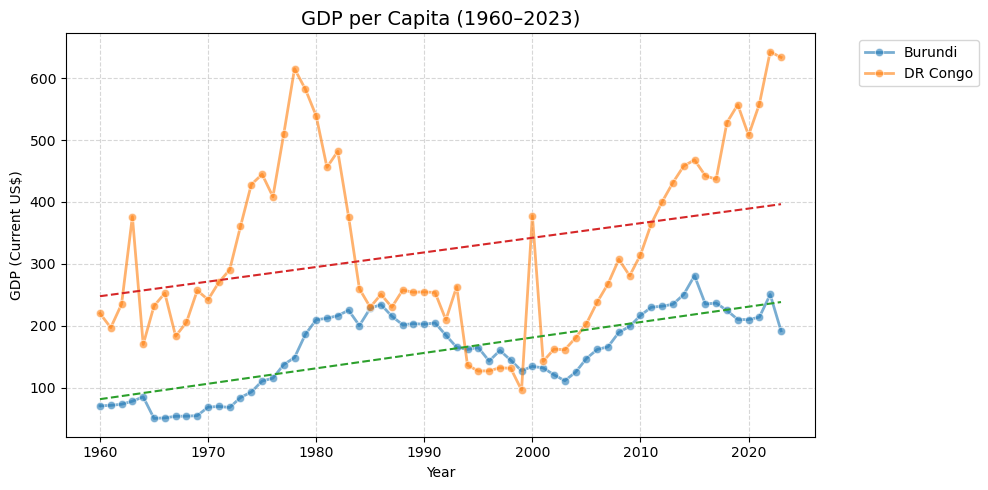

In [9]:
plot_trend_with_regression(data, 'GDP', 'GDP per Capita (1960–2023)', 'GDP (Current US$)', 'gdp_trend_clean.png')

<b>Insights</b>
- DR Congo consistently has higher GDP per capita than Burundi, although the values for both remain very low globally.

- Volatility in DRC likely reflects:

    - Periods of conflict (e.g., First and Second Congo Wars)

    - Commodity price fluctuations (e.g., copper, cobalt)

- Burundi's GDP remains more stable but stagnant, suggesting structural underdevelopment and persistent poverty

# 2. Health Trends: Life Expectancy

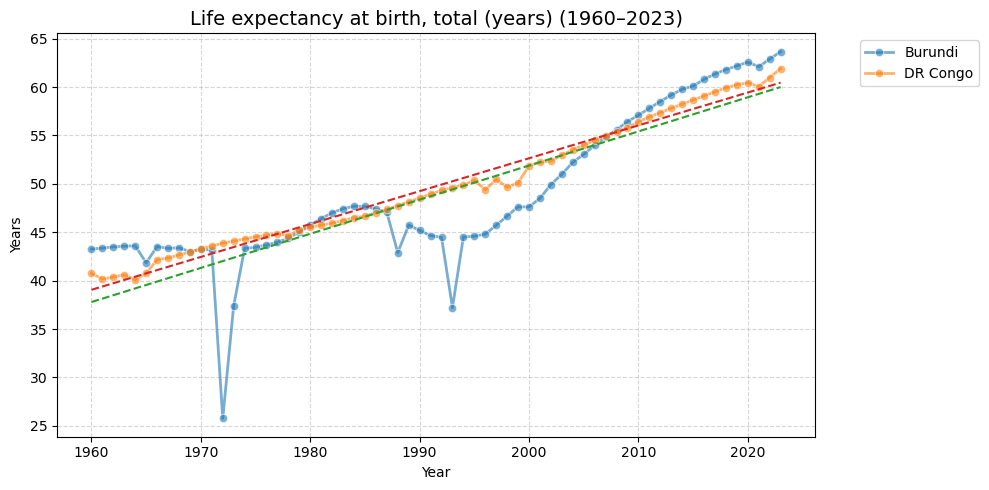

In [10]:
plot_trend_with_regression(data, 'Life Expectancy', 'Life expectancy at birth, total (years) (1960–2023)', 'Years', 'life_expectancy_clean.png')


<b>Insights</b>
- Both countries have converged to similar life expectancy values (~60 years) in the past decade.

- This convergence suggests some public health progress, despite economic stagnation.

- Key contributing factors:
 
    - Expanded access to vaccines and public health programs

    - Reduced child mortality and improved maternal care

    - Regional and international health aid

- Historical dips in life expectancy align with civil conflict and disease outbreaks:

    - Burundi Civil War (1993–2005)

    - Ebola and other crises in DRC

# 3. Environmental Trends: CO₂ Emissions 

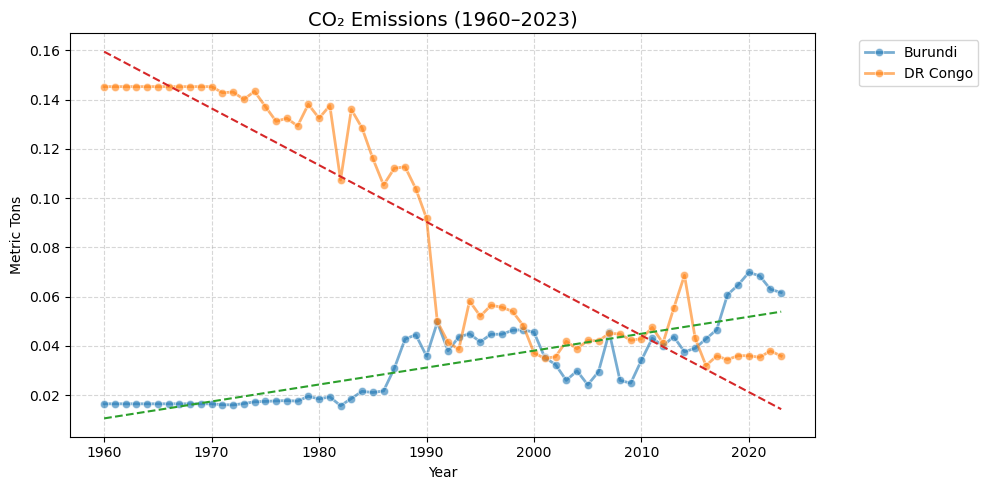

In [11]:
plot_trend_with_regression(data, 'CO2', 'CO₂ Emissions (1960–2023)', 'Metric Tons', 'co2_trend_clean.png')


- CO₂ emissions remain negligible for both nations across the entire timeline.

- Burundi has especially low emissions, reinforcing its status as one of the world’s least industrialized countries.
-  DR Congo, while more populous and resource-rich, also maintains a low carbon footprint.

<B> Insight: </B> Both economies rely heavily on subsistence agriculture and biomass, with limited fossil fuel combustion or industrial activity.

<H1> Key Insights </H1>

**Economic Disparity:** DRC has higher GDP per capita, but Burundi is more stable.

**Health Convergence:** Despite differing paths, both countries now show similar life expectancies.

**Low Environmental Impact:** Minimal emissions suggest under-industrialization rather than deliberate sustainability.

# Conclusion: 
This comparative analysis of DR Congo and Burundi from 1960 to 2023 reveals a complex development landscape marked by persistent economic challenges, modest public health improvements, and minimal environmental impact. While DR Congo exhibits higher but volatile GDP per capita, Burundi’s economy remains more stable but significantly less dynamic. Despite these economic disparities, both nations have achieved a convergence in life expectancy, reflecting progress in basic healthcare and international development support.

Moreover, both countries continue to maintain extremely low per capita CO₂ emissions, underscoring their limited industrial activity rather than sustainable economic transformation. These insights emphasize the need for context-specific development strategies that simultaneously promote economic resilience, health equity, and low-carbon growth.

The presented workflow is fully reproducible and scalable, supporting ongoing policy monitoring and development planning through open-source tools, clean code, and visual analytics.

